In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

## Defining the function and solution

In [47]:
c = 2
def u(x, t):
    i = x - c * t
    func = torch.sin(i)
    return func

def ux(x, t):
    i = x - c * t
    func = torch.cos(i)
    return func

In [55]:
# Domain
x = torch.rand(100,1, requires_grad=True)
t = torch.rand(100,1, requires_grad=True)
u_exact = u(x, t)

# Initial
x_i = torch.rand(10,1,requires_grad=True)
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = u(x_i, t_i)

# Boundary
x_b = torch.cat((torch.zeros(5,1, requires_grad=True),torch.ones(5,1, requires_grad=True)))
t_b = torch.rand(x_b.shape, requires_grad=True)
u_b = u(x_b, t_b)

Text(0.5, 1.0, 'Training points in domain')

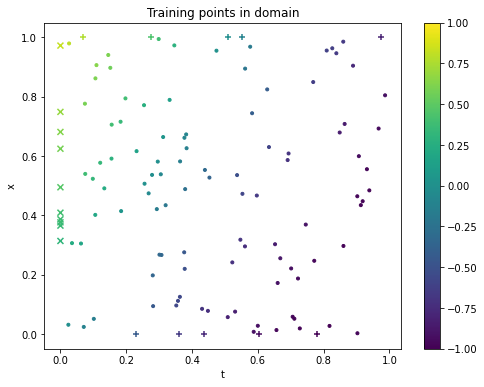

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), c=u_exact.detach(), marker='.', label='Domain', vmax=1, vmin=-1)
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', label='Initial', vmax=1, vmin=-1)
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', label='Boundary', vmax=1, vmin=-1)
fig.colorbar(d)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')

In [87]:
N_in = 2
N_out = 1
N_hid = 10
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
                nn.Sigmoid(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_i)
        loss = self.loss_func(u_b, u_b_hat)
        return loss
    
    def loss_Initial(self, x_i, t_i, u_i)
        u_i_hat = self.forward(x_i, t_i)

    def loss_PDE(self, x, t, u_x):
        u_hat = self.forward(x)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        loss = self.loss_func(u_xx, u_xx_hat)
        return loss
    
    def loss(self, x, u_xx, x_b, u_b):
        loss = self.loss_BC(x_b, u_b) + self.loss_PDE(x, u_xx)
        return loss
    
    def step(self, x, u_x, x_b, u_b):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, u_xx, x_b, u_b)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_BC(x_b, u_b), self.loss_PDE(x, u_xx)
net = Net(N_in, N_out, N_hid=10)